In [64]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [65]:
def parse_example(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type=tf.float32)
    image = tf.reshape(image, [122, 122, 3])
    
    label = example['label']
    return image, label

def load_tfrecord(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_ds = load_tfrecord('trainft.tfrecord')
val_ds = load_tfrecord('valft.tfrecord')

train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


try with imagenet pretrained weights

In [66]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, MobileNetV3Small
from tensorflow.keras.applications.efficientnet import preprocess_input

In [67]:
input_shape=(122, 122, 3)

base_model = MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)
base_model.trainable = False

In [68]:
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Lambda(preprocess_input)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [69]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=10, 
                    callbacks=[early_stop, lr_reduction])

Epoch 1/10
232/232 [==============================] - 7s 17ms/step - loss: 2.2387 - accuracy: 0.2579 - val_loss: 1.6660 - val_accuracy: 0.3785 - lr: 0.0010
Epoch 2/10
232/232 [==============================] - 3s 13ms/step - loss: 1.7501 - accuracy: 0.3577 - val_loss: 1.5960 - val_accuracy: 0.4142 - lr: 0.0010
Epoch 3/10
232/232 [==============================] - 3s 13ms/step - loss: 1.5284 - accuracy: 0.4339 - val_loss: 1.5785 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 4/10
232/232 [==============================] - 3s 13ms/step - loss: 1.4106 - accuracy: 0.4792 - val_loss: 1.5775 - val_accuracy: 0.4207 - lr: 0.0010
Epoch 5/10
232/232 [==============================] - 3s 13ms/step - loss: 1.3017 - accuracy: 0.5190 - val_loss: 1.6037 - val_accuracy: 0.4331 - lr: 0.0010
Epoch 6/10
232/232 [==============================] - 3s 13ms/step - loss: 1.1877 - accuracy: 0.5643 - val_loss: 1.6663 - val_accuracy: 0.4185 - lr: 0.0010
Epoch 7/10
232/232 [==============================] - 3s 14ms/st

In [70]:
model.trainable = True
for layer in model.layers[:-20]:
    layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=10, 
                    callbacks=[early_stop, lr_reduction])

Epoch 1/10
232/232 [==============================] - 11s 31ms/step - loss: 1.2107 - accuracy: 0.5617 - val_loss: 1.5341 - val_accuracy: 0.4348 - lr: 1.0000e-05
Epoch 2/10
232/232 [==============================] - 6s 27ms/step - loss: 1.1718 - accuracy: 0.5792 - val_loss: 1.5225 - val_accuracy: 0.4407 - lr: 1.0000e-05
Epoch 3/10
232/232 [==============================] - 6s 27ms/step - loss: 1.1417 - accuracy: 0.5813 - val_loss: 1.5164 - val_accuracy: 0.4450 - lr: 1.0000e-05
Epoch 4/10
232/232 [==============================] - 6s 27ms/step - loss: 1.1120 - accuracy: 0.5989 - val_loss: 1.5090 - val_accuracy: 0.4461 - lr: 1.0000e-05
Epoch 5/10
232/232 [==============================] - 6s 27ms/step - loss: 1.0874 - accuracy: 0.6074 - val_loss: 1.5023 - val_accuracy: 0.4537 - lr: 1.0000e-05
Epoch 6/10
232/232 [==============================] - 6s 28ms/step - loss: 1.0674 - accuracy: 0.6147 - val_loss: 1.5000 - val_accuracy: 0.4575 - lr: 1.0000e-05
Epoch 7/10
232/232 [===================

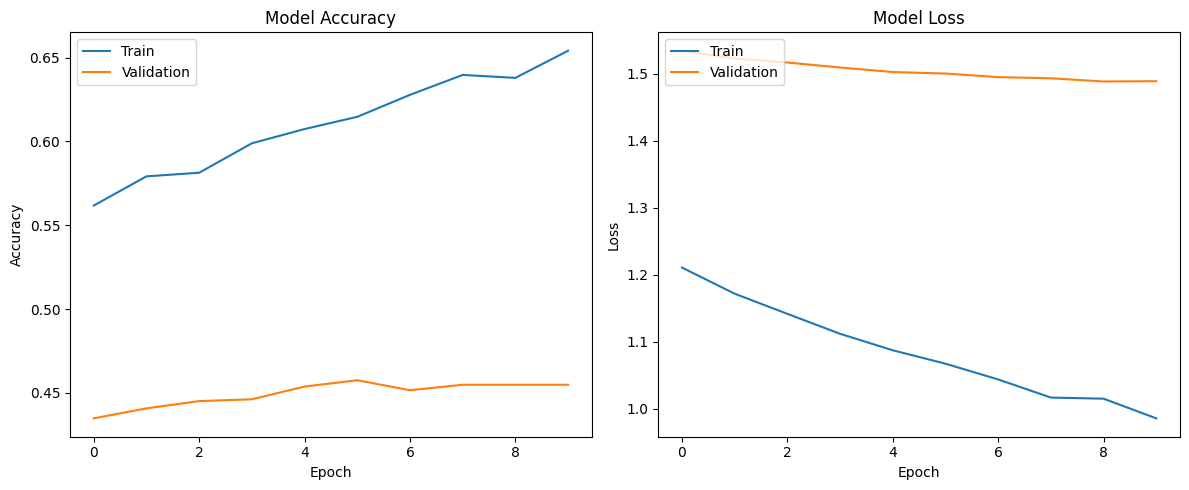

In [71]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [72]:
k = []
for i in range(100):
    k.append(i)
    
print(k[:-20])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


In [73]:
model.save("./models/ft0.54-1.54.keras")